In [ ]:
#@title Install dependencies for LunarLander.
!apt-get install swig > /dev/null 2>&1
!pip install gymnasium > /dev/null 2>&1
!pip install gymnasium[box2d] > /dev/null 2>&1
!pip install gymnasium[classic-control]

In [ ]:
#@title Import required libraries.

import pandas as pd
import gymnasium as gym
import numpy as np
import random
import seaborn as sns

from IPython import display
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam
import numpy as np
from gymnasium.spaces import Discrete, Box

In [ ]:
#@title Build a feedforward neural network.

# Build a feedforward neural network with fully connected layers.
# sizes: Defines network dimensions. For sizes = [8, 32, 3], we have 2 layers in
#        total. The first layer expects input of dimension 8 (excluding batch
#        dimension), and gives 32 dimensional output. The second layer expects
#        input of dimension 32 and gives 3 dimensional output.
# activation: Activation function for all layers except final layer. Should add
#             non linearity. The final layer does not apply any activation.
def mlp(sizes, activation=nn.Tanh):
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else nn.Identity
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

####PolicyGradientTrainer
  * `self.policy_model`: Neural network with fully connected layers.
    * Assumes: continuous state space and discrete action space.
    * Output layer has n_action units.
  * `train_one_epoch`: Makes one policy gradient update to `self.policy_model`.
  * `train`: Trains the policy for some epochs.
    * Calls `train_one_epoch` repeatedly.
    * Returns trained `self.policy_model` and training statistics.
  * `eval`: Evaluate the trained policy by acting in the environment using the current policy for one episode.
    * The episode is visualized.
    * No gradient update is made.


####Training Stats
* Episode returns.
* Episode length.



In [ ]:
#@title PolicyGradientTrainer class.
# Trains a policy using Monte Carlo policy gradient update (REINFORCE).
class PolicyGradientTrainer():
    def __init__(self, env_name: str = 'LunarLander-v2', lr: float = 1e-2,
                 max_eps_length: int = 500, epochs: int = 50, n_steps_per_epoch: int = 5000,
                 hidden_sizes: list[int] = [32], verbose: bool = False):
        # Create the environment.
        self.env = gym.make(env_name, render_mode="rgb_array")
        # Obtain observation (ie state) dimension and action dimension from the environment.
        obs_dim = self.env.observation_space.shape[0]
        n_acts = self.env.action_space.n

        # Create the policy model, composed from fully connected layers expecting
        # input of `obs_dim` and output `n_acts` units.
        self.policy_model = mlp(sizes=[obs_dim] + hidden_sizes + [n_acts])
        # Create gradient descent optimizer for the policy model.
        self.optimizer = Adam(self.policy_model.parameters(), lr=lr)

        # Specify how many experiences we will use to train the policy.
        self.epochs = epochs
        self.n_steps_per_epoch = n_steps_per_epoch
        self.max_eps_length = max_eps_length

        # In verbose mode, trainer will print training stats to screen.
        self.verbose = verbose

    # Returns current policy for `obs`, ie the probability distribution of actions at `obs`: pi(*|obs)
    def get_policy(self, obs):
        logits = self.policy_model(obs)
        return Categorical(logits=logits)

    # Samples action at `obs` according to the current policy. We first compute the probaility
    # distribution of actions using `self.get_policy`, then sample an action from the distribution.
    def get_action(self, obs):
        return self.get_policy(obs).sample().item()

    # Compute loss. The gradient of this loss function is equal to the policy gradient
    # we derived for REINFORCE algorithm, using log probability of actions and their returns,
    # from all timestamps across all trajectories.
    def compute_loss(self, all_obs, all_acts, all_returns):
        all_logps = self.get_policy(all_obs).log_prob(all_acts)
        return -(all_logps * all_returns).mean()

    # Make one policy gradient update.
    def train_one_epoch(self):
        # Accumulate observations, actions and returns at all timestamps for the current epoch.
        epoch_obs = []          # for observations
        epoch_acts = []         # for actions
        epoch_returns = []      # for returns in policy gradient

        # Accumulate episode level information for logging.
        episode_returns = []      # for measuring episode returns
        episode_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs, _ = self.env.reset()       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        episode_rewards = []            # list for rewards accrued throughout ep

        t = 0

        # collect experience by acting in the environment with current policy
        while True:

            # Save the observation.
            epoch_obs.append(obs.copy())

            # Act in the environment
            act = self.get_action(torch.as_tensor(obs, dtype=torch.float32))
            obs, rew, done, truncated, _ = self.env.step(act)

            # Save action and reward.
            epoch_acts.append(act)
            episode_rewards.append(rew)
            t += 1

            # The episode is over when any of the following condition is reached.
            # (1) environment returned "done": lander landed or crashed.
            # (2) we have collected `self.n_steps_per_epoch` actions for the epoch.
            # (3) the current episode has reached `self. max_eps_length` length.
            if (done or
                len(epoch_obs) > self.n_steps_per_epoch or
                t >=self.max_eps_length):

                # Calculate the cumulative reward for the episode, from time 0 to episode end.
                episode_return = sum(episode_rewards)
                # Calulate the length of the episode.
                episode_len = len(episode_rewards)
                episode_returns.append(episode_return)
                episode_lens.append(episode_len)

                # all timestamps in the episode have the sampe return: episode_return
                epoch_returns += [episode_return] * episode_len

                # reset episode-specific variables
                obs, _ = self.env.reset()
                t = 0
                done, episode_rewards = False, []

                # end experience loop if we have enough of it
                if len(epoch_obs) > self.n_steps_per_epoch:
                    break

        # Take a single policy gradient update step with back propagation.
        self.optimizer.zero_grad()
        epoch_loss = self.compute_loss(all_obs=torch.as_tensor(epoch_obs, dtype=torch.float32),
                                       all_acts=torch.as_tensor(epoch_acts, dtype=torch.int32),
                                       all_returns=torch.as_tensor(epoch_returns, dtype=torch.float32)
                                      )
        epoch_loss.backward()
        self.optimizer.step()

        return epoch_loss, episode_returns, episode_lens

    # Train the policy model and return training statistics.
    def train(self):
        # Initialize dictionary for per epoch training stats.
        train_stats = {'iteration': [],
                       'epoch_loss': [],
                       'episode_returns': [],
                       'episode_lens': []}

        # Trains the policy and accumulate training stats.
        for i in range(self.epochs):
            epoch_loss, episode_rets, episode_lens = self.train_one_epoch()
            if self.verbose:
                print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                      (i, epoch_loss, np.mean(episode_rets), np.mean(episode_lens)))
            for episode_ret in episode_rets:
              train_stats['iteration'].append(i)
              train_stats['epoch_loss'].append(float(epoch_loss.detach().numpy()))
              train_stats['episode_returns'].append(episode_ret)
              train_stats['episode_lens'].append(np.mean(episode_lens))
        df_train_stats = pd.DataFrame(data=train_stats)

        return df_train_stats

    # Evaluate the policy model by acting in the environment for one episode.
    def eval(self, render_every: int = 1):
        # Start the episode from environment starting distribution.
        obs, _ = self.env.reset()
        t = 0
        ret = 0

        # Act in the environment with current policy.
        while True:
            # Display the observation at `render_every` intervals.
            if t % render_every == 0:
                display.clear_output(wait=True)
                plt.imshow(self.env.render())
                plt.show()

            # Take action using the current policy.
            act = self.get_action(torch.as_tensor(obs, dtype=torch.float32))
            obs, rew, done, truncated, _ = self.env.step(act)

            t += 1
            ret += rew

            if done or truncated or t > self.max_eps_length:
              break

        print(f'return = {ret}. episode length = {t + 1}')


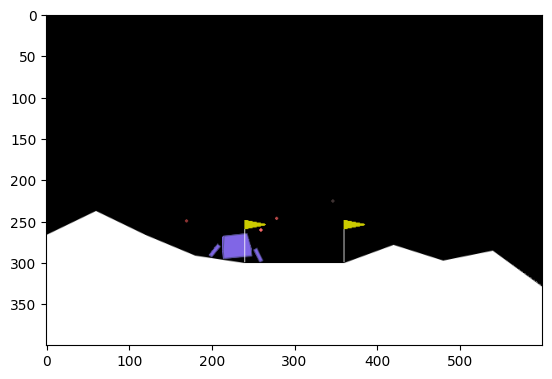

return = -102.4816391626334. episode length = 69


In [ ]:
#@title Visualize lander behavior under random, untrained policy
untrained = PolicyGradientTrainer(env_name='LunarLander-v2', lr=1e-2, max_eps_length=500, n_steps_per_epoch=5000, epochs=300)
untrained.eval()

In [ ]:
#@title Train the policy
trained = PolicyGradientTrainer(env_name='LunarLander-v2', lr=1e-2, max_eps_length=500, n_steps_per_epoch=5000, epochs=300, verbose=True)
stats = trained.train()

<ipython-input-4-015746879d0b>:106: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  epoch_loss = self.compute_loss(all_obs=torch.as_tensor(epoch_obs, dtype=torch.float32),


epoch:   0 	 loss: -285.874 	 return: -200.776 	 ep_len: 86.224
epoch:   1 	 loss: -302.892 	 return: -207.759 	 ep_len: 92.611
epoch:   2 	 loss: -277.518 	 return: -193.743 	 ep_len: 87.737
epoch:   3 	 loss: -307.586 	 return: -215.078 	 ep_len: 87.737
epoch:   4 	 loss: -267.807 	 return: -186.865 	 ep_len: 87.737
epoch:   5 	 loss: -202.964 	 return: -161.157 	 ep_len: 89.304
epoch:   6 	 loss: -212.378 	 return: -149.196 	 ep_len: 92.611
epoch:   7 	 loss: -200.800 	 return: -144.394 	 ep_len: 86.224
epoch:   8 	 loss: -219.606 	 return: -154.895 	 ep_len: 86.224
epoch:   9 	 loss: -198.787 	 return: -145.149 	 ep_len: 86.224
epoch:  10 	 loss: -203.839 	 return: -143.141 	 ep_len: 84.763
epoch:  11 	 loss: -174.281 	 return: -124.499 	 ep_len: 83.350
epoch:  12 	 loss: -190.448 	 return: -134.161 	 ep_len: 81.984
epoch:  13 	 loss: -167.350 	 return: -118.798 	 ep_len: 79.381
epoch:  14 	 loss: -169.414 	 return: -123.518 	 ep_len: 84.763
epoch:  15 	 loss: -161.794 	 return: -1

In [ ]:
#@title Visualize trained policy
trained.eval()

NameError: ignored

In [ ]:
dir()

['In',
 'Out',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i2',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 'exit',
 'get_ipython',
 'quit']

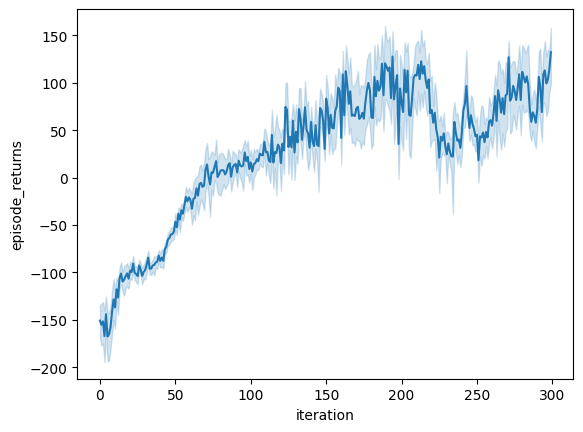

In [ ]:
#@title Plot episode returns per epoch.
_ = sns.lineplot(data=stats, x="iteration", y="episode_returns")

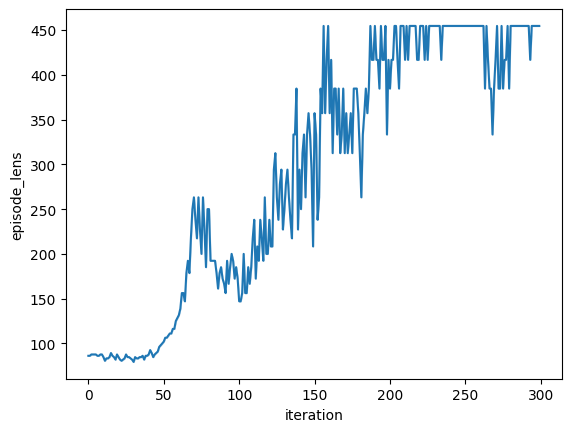

In [ ]:
#@title Plot episode lengths per epoch.
_ = sns.lineplot(data=stats, x="iteration", y="episode_lens")